In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r /content/drive/MyDrive/ImageSegmentationData /content/image_data

In [4]:
import torchvision.transforms as transforms
import cv2
import numpy
import numpy as np
from google.colab.patches import cv2_imshow

In [70]:
image = cv2.imread('/content/image_data/Image2.jpg')

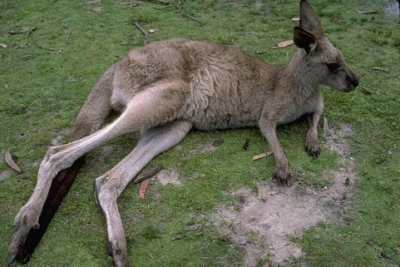

In [71]:
cv2_imshow(image)

In [72]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [73]:
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

In [74]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [75]:
def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image) # get the predictions on the image
    # print the results individually
    # print(f"BOXES: {outputs[0]['boxes']}")
    # print(f"LABELS: {outputs[0]['labels']}")
    # print(f"SCORES: {outputs[0]['scores']}")
    # get all the predicited class names
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    return boxes, pred_classes, outputs[0]['labels']

In [76]:
def draw_boxes(boxes, classes, labels, image):
    # read the image with OpenCV
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

In [77]:
import torchvision
import torch

In [78]:
min_size = 800
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, 
                                                    min_size=min_size)

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

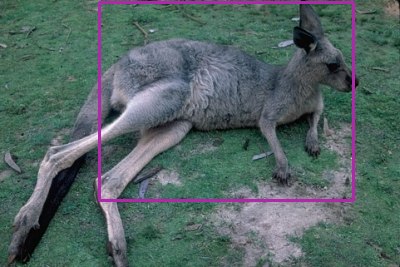

In [80]:
model.eval().to(device)
boxes, classes, labels = predict(image, model, device, 0.9)
image_2 = draw_boxes([boxes[0]], classes, labels, image.copy())
cv2_imshow(image_2)

In [81]:
boxes

array([[ 99,   2, 353, 200]], dtype=int32)

In [82]:
bbox = boxes[0]

In [83]:
mask = np.zeros(image.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

In [84]:
cv2.grabCut(image,mask,bbox,bgdModel,fgdModel,200,cv2.GC_INIT_WITH_RECT)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[2.61799555e-01, 1.43405979e-01, 1.68164565e-01, 2.43374828e-01,
         1.83255073e-01, 7.82398202e+01, 1.14228274e+02, 9.66876873e+01,
         1.40388656e+02, 1.39238053e+02, 1.49913194e+02, 3.65054199e+01,
         6.59879254e+01, 5.65980379e+01, 6.23638303e+01, 9.98384925e+01,
         8.39562930e+01, 8.50035256e+01, 1.00564279e+02, 9.88588517e+01,
         4.95107041e+01, 4.68947969e+01, 5.41469507e+01, 4.68947969e+01,
         8.12341591e+01, 7.20620827e+01, 5.41469507e+01, 7.20620827e+01,
         7.97536418e+01, 8.07208801e+02, 6.96281574e+02, 7.37251678e+02,
         6.96281574e+02, 6.14192969e+02, 6.46430640e+02, 7.37251678e+02,
         6.46430640e+02, 6.93724967e+02, 2.69285371e+02, 4.61002124e+02,
         3.74842635e+02, 4.61002124e+02, 8.9

In [85]:
mask3 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
mask2 = np.where((mask==2)|(mask==0), 0, 255).astype('uint8')
output = image*mask3[:,:,np.newaxis]

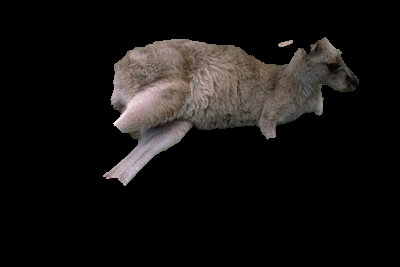

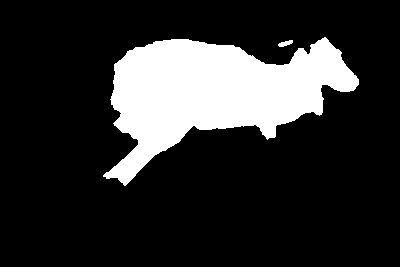

In [ ]:
cv2_imshow(output)
cv2_imshow(mask2)

In [ ]:
y_pred = mask2
y_true = cv2.imread('/content/image_data/Image1_GT.png')
y_true = cv2.cvtColor(y_true, cv2.COLOR_BGR2GRAY)

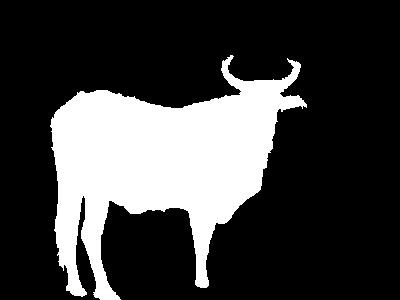

In [ ]:
cv2_imshow(y_true)

In [ ]:
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [ ]:
dice_score = dice(y_pred, y_true, k = 255) #255 in my case, can be 1 
print ("Dice Similarity: {}".format(dice_score))

Dice Similarity: 0.9640305029560449


In [89]:
image = cv2.imread('/content/image_data/Image3.jpg')

In [92]:
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
segments_fz = felzenszwalb(image, scale=500, sigma=0.5, min_size=50)

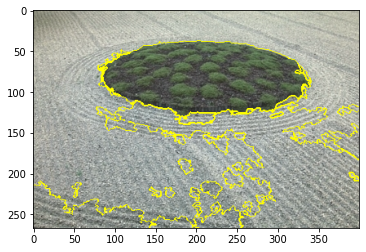

In [93]:
import matplotlib.pyplot as plt
plt.imshow(mark_boundaries(image, segments_fz))

In [61]:
s = {}
for i in range (segments_fz.shape[0]):
  for j in range (segments_fz.shape[1]):
    if segments_fz[i][j] in s:
      s[segments_fz[i][j]] += 1
    else: s[segments_fz[i][j]] = 1

In [63]:
for i in range (segments_fz.shape[0]):
  for j in range (segments_fz.shape[1]):
    if segments_fz[i][j] != 0:
      segments_fz[i][j] = 1

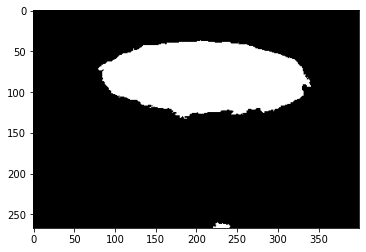

In [64]:
plt.imshow(segments_fz, cmap = 'gray')

In [67]:
plt.imsave('Image3_seg.png', segments_fz, cmap = 'gray')

In [68]:
segments_fz.shape

(267, 400)

In [69]:
image.shape

(267, 400, 3)